In [48]:
from dask import bag
from dask.diagnostics import ProgressBar
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os

import matplotlib.pyplot as plt

'0.9.1'

In [49]:
missing_migrants = pd.read_csv('MissingMigrants_Global_2019.csv')
missing_migrants.head()

,Web_ID,Region_of_Incident,Reported_Date,Reported_Year,Reported_Month,Number_Dead,Minimum_Estimated_Number_of_Missing,Total_Dead_and_Missing,Number_of_Survivors,Number_of_Females,...,Number_of_Children,Cause_of_Death,Location_Description,Information_Source,Latitude,Longitude,Migration_Route,URL,UNSD_Geographical_Grouping,Source_Quality
0,51591,Mediterranean,"March 28, 2019",2019,Mar,0,2,2,36,0,...,0,Presumed drowning,"Off the coast of Chios, Greece",Hellenic Coast Guard via IOM Greece,38.362369,26.172509,Eastern Mediterranean,Not Available,Uncategorized,5
1,51588,Mediterranean,"March 26, 2019",2019,Mar,4,0,4,11,3,...,1,Presumed drowning,"Off the coast of Ayvacık district, Çanakkale p...",Turkish Coast Guard via IOM Turkey,39.441976,26.378816,Eastern Mediterranean,http://bit.ly/2YmiPAN,Uncategorized,5
2,51589,Mediterranean,"March 26, 2019",2019,Mar,1,0,1,0,0,...,0,Presumed drowning,"Body recovered on Playa del Tarajal, Ceuta, Sp...","Ceuta al día, El Pueblo de Ceuta",35.871902,-5.343038,Western Mediterranean,"http://bit.ly/2uyj7qO, http://bit.ly/2uwj5zC",Uncategorized,3
3,51590,Mediterranean,"March 26, 2019",2019,Mar,1,0,1,0,0,...,0,Presumed drowning,"Body recovered on beach near Tetouan, Morocco ...",El Pueblo de Ceuta,35.635116,-5.275650,Western Mediterranean,http://bit.ly/2uwj5zC,Uncategorized,1
4,51587,Central America,"March 25, 2019",2019,Mar,1,0,1,0,0,...,0,Fall from train,"Train tracks in Teacalco, Tlaxcala, Mexico","Megalópolis, Línea de contraste",19.334475,-98.069824,Unknown,"http://bit.ly/2uvDIvH, http://bit.ly/2TXAFLS",Central America,3


In [50]:
missing_migrants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 21 columns):
Web_ID                                 5333 non-null int64
Region_of_Incident                     5333 non-null object
Reported_Date                          5333 non-null object
Reported_Year                          5333 non-null int64
Reported_Month                         5333 non-null object
Number_Dead                            5333 non-null int64
Minimum_Estimated_Number_of_Missing    5333 non-null int64
Total_Dead_and_Missing                 5333 non-null int64
Number_of_Survivors                    5333 non-null int64
Number_of_Females                      5333 non-null int64
Number_of_Males                        5333 non-null int64
Number_of_Children                     5333 non-null int64
Cause_of_Death                         5333 non-null object
Location_Description                   5323 non-null object
Information_Source                     5331 non-null object
La

In [51]:
df = missing_migrants[['Region_of_Incident','Total_Dead_and_Missing','Number_of_Survivors','Source_Quality','URL',
                      'Reported_Year']]

In [52]:
df['Reliablity'] = df.Source_Quality.apply(lambda x: 1 if x > 3 else 0)
df['URL_Existance'] = df.URL.apply(lambda x: 1 if x =='Not Available' else 0)

In [53]:
df.head()

,Region_of_Incident,Total_Dead_and_Missing,Number_of_Survivors,Source_Quality,URL,Reported_Year,Reliablity,URL_Existance
0,Mediterranean,2,36,5,Not Available,2019,1,1
1,Mediterranean,4,11,5,http://bit.ly/2YmiPAN,2019,1,0
2,Mediterranean,1,0,3,"http://bit.ly/2uyj7qO, http://bit.ly/2uwj5zC",2019,0,0
3,Mediterranean,1,0,1,http://bit.ly/2uwj5zC,2019,0,0
4,Central America,1,0,3,"http://bit.ly/2uvDIvH, http://bit.ly/2TXAFLS",2019,0,0


In [54]:
df.describe()

,Total_Dead_and_Missing,Number_of_Survivors,Source_Quality,Reported_Year,Reliablity,URL_Existance
count,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000,5333.000000
mean,5.916370,8.933433,2.895556,2016.656104,0.383274,0.401463
std,28.051811,59.162322,1.423257,1.237033,0.486230,0.490240
min,0.000000,0.000000,1.000000,2014.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000,2016.000000,0.000000,0.000000
50%,1.000000,0.000000,2.000000,2017.000000,0.000000,0.000000
75%,3.000000,0.000000,4.000000,2018.000000,1.000000,1.000000
max,1022.000000,1950.000000,5.000000,2019.000000,1.000000,1.000000


In [55]:
df.describe(include=['O'])

,Region_of_Incident,URL
count,5333,5333
unique,15,2049
top,US-Mexico Border,Not Available
freq,1337,2141


In [56]:
dummy = pd.get_dummies(df['Region_of_Incident'])
dummy.head()

,Caribbean,Central America,Central Asia,East Asia,Europe,Horn of Africa,Mediterranean,Middle East,North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,US-Mexico Border
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
df = df.merge(dummy,left_index=True, right_index=True)
df.head(10)

,Region_of_Incident,Total_Dead_and_Missing,Number_of_Survivors,Source_Quality,URL,Reported_Year,Reliablity,URL_Existance,Caribbean,Central America,...,Horn of Africa,Mediterranean,Middle East,North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,US-Mexico Border
0,Mediterranean,2,36,5,Not Available,2019,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Mediterranean,4,11,5,http://bit.ly/2YmiPAN,2019,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Mediterranean,1,0,3,"http://bit.ly/2uyj7qO, http://bit.ly/2uwj5zC",2019,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Mediterranean,1,0,1,http://bit.ly/2uwj5zC,2019,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Central America,1,0,3,"http://bit.ly/2uvDIvH, http://bit.ly/2TXAFLS",2019,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,US-Mexico Border,1,0,5,http://www.humaneborders.info/,2019,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,US-Mexico Border,1,0,5,http://www.humaneborders.info/,2019,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,Southeast Asia,10,0,3,"http://bit.ly/2YqrMsT, http://bit.ly/2TzbavA",2019,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,Mediterranean,8,0,3,"http://bit.ly/2U1K4C4, http://bit.ly/2HJW70B, ...",2019,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9,US-Mexico Border,1,0,5,http://www.humaneborders.info/,2019,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [58]:
df = df[['Total_Dead_and_Missing','Number_of_Survivors','Reliablity','URL_Existance','Reported_Year',
         'Caribbean','Central America','Central Asia','East Asia','Europe','Horn of Africa','Mediterranean',
         'Middle East','North Africa','North America','South America','South Asia','Southeast Asia',
         'Sub-Saharan Africa','US-Mexico Border']]
df.head()

,Total_Dead_and_Missing,Number_of_Survivors,Reliablity,URL_Existance,Reported_Year,Caribbean,Central America,Central Asia,East Asia,Europe,Horn of Africa,Mediterranean,Middle East,North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,US-Mexico Border
0,2,36,1,1,2019,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,4,11,1,0,2019,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,2019,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,2019,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,2019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [60]:
X = df.loc[:, df.columns != 'Reliablity']
y = df.loc[:, df.columns == 'Reliablity']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [71]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Reliablity'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of unreliable data in oversampled data",len(os_data_y[os_data_y['Reliablity']==0]))
print("Number of reliable",len(os_data_y[os_data_y['Reliablity']==1]))
print("Proportion of unreliable data in oversampled data is ",len(os_data_y[os_data_y['Reliablity']==0])/len(os_data_X))
print("Proportion of reliable data in oversampled data is ",len(os_data_y[os_data_y['Reliablity']==1])/len(os_data_X))

length of oversampled data is  4554
Number of unreliable data in oversampled data 2277
Number of reliable 2277
Proportion of unreliable data in oversampled data is  0.5
Proportion of reliable data in oversampled data is  0.5


/Users/xiening/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
data_final_vars=df.columns.values.tolist()
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/Users/xiening/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [64]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.356057
         Iterations: 35
                                Results: Logit
Model:                    Logit                Pseudo R-squared:     0.465    
Dependent Variable:       Reliablity           AIC:                  3835.7093
Date:                     2019-08-21 18:48     BIC:                  3960.7610
No. Observations:         5333                 Log-Likelihood:       -1898.9  
Df Model:                 18                   LL-Null:              -3549.9  
Df Residuals:             5314                 LLR p-value:          0.0000   
Converged:                0.0000               Scale:                1.0000   
No. Iterations:           35.0000                                             
------------------------------------------------------------------------------
                         Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
------------------------------------------------------------------------------
Total_Dead_and_Mis

/Users/xiening/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [65]:
df.corr()

,Total_Dead_and_Missing,Number_of_Survivors,Reliablity,URL_Existance,Reported_Year,Caribbean,Central America,Central Asia,East Asia,Europe,Horn of Africa,Mediterranean,Middle East,North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,US-Mexico Border
Total_Dead_and_Missing,1.000000,0.123441,0.104803,-0.045263,-0.109814,0.009583,-0.034599,0.022500,0.000310,-0.032675,-0.007763,0.213828,-0.021850,-0.052291,-0.002400,-0.006814,-0.024479,0.082211,-0.029602,-0.091715
Number_of_Survivors,0.123441,1.000000,0.085649,-0.059306,-0.058410,-0.007063,-0.019393,-0.000911,-0.002140,-0.028447,-0.002168,0.257775,-0.018013,-0.076606,-0.002068,-0.008427,-0.024708,-0.001207,-0.037706,-0.085596
Reliablity,0.104803,0.085649,1.000000,0.126210,-0.046171,-0.050195,-0.169094,-0.010796,-0.011548,-0.033701,-0.094089,0.272291,0.138825,-0.410850,-0.010796,-0.046599,0.084000,0.003498,-0.218071,0.384919
URL_Existance,-0.045263,-0.059306,0.126210,1.000000,-0.344116,-0.086623,-0.190012,-0.011216,-0.025089,-0.164930,0.088822,-0.128237,-0.139233,0.332953,-0.011216,-0.059499,0.076979,-0.099376,-0.041221,0.047875
Reported_Year,-0.109814,-0.058410,-0.046171,-0.344116,1.000000,-0.045958,-0.016050,0.014879,-0.016249,-0.015355,-0.045192,-0.078399,0.032839,-0.035506,0.003808,0.028589,0.049288,0.002296,0.202959,-0.016862
Caribbean,0.009583,-0.007063,-0.050195,-0.086623,-0.045958,1.000000,-0.026231,-0.001448,-0.003240,-0.023407,-0.022709,-0.050311,-0.018840,-0.058186,-0.001448,-0.007684,-0.018055,-0.014320,-0.033073,-0.061180
Central America,-0.034599,-0.019393,-0.169094,-0.190012,-0.016050,-0.026231,1.000000,-0.003396,-0.007597,-0.054885,-0.053246,-0.117966,-0.044175,-0.136432,-0.003396,-0.018017,-0.042334,-0.033578,-0.077548,-0.143452
Central Asia,0.022500,-0.000911,-0.010796,-0.011216,0.014879,-0.001448,-0.003396,1.000000,-0.000420,-0.003031,-0.002940,-0.006514,-0.002439,-0.007534,-0.000188,-0.000995,-0.002338,-0.001854,-0.004282,-0.007922
East Asia,0.000310,-0.002140,-0.011548,-0.025089,-0.016249,-0.003240,-0.007597,-0.000420,1.000000,-0.006780,-0.006577,-0.014572,-0.005457,-0.016853,-0.000420,-0.002226,-0.005229,-0.004148,-0.009579,-0.017720
Europe,-0.032675,-0.028447,-0.033701,-0.164930,-0.015355,-0.023407,-0.054885,-0.003031,-0.006780,1.000000,-0.047515,-0.105269,-0.039420,-0.121747,-0.003031,-0.016078,-0.037778,-0.029963,-0.069201,-0.128012


In [66]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/xiening/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/xiening/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[773 239]
 [ 66 522]]


In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.76      0.84      1012
           1       0.69      0.89      0.77       588

    accuracy                           0.81      1600
   macro avg       0.80      0.83      0.80      1600
weighted avg       0.83      0.81      0.81      1600



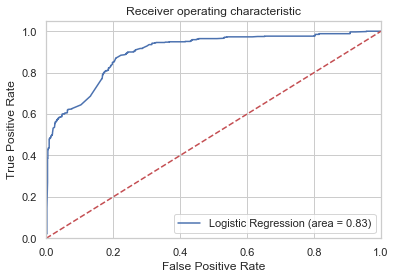

In [70]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()